#Procesamiento de Lenguaje Natural - Text Classification - Deep Learning CNN Models
Jonnatan Arias Garcia - Uniquindio - Utp
jonnatan.arias@utp.edu.co
jariasg@uniquindio.edu.co


Las redes neuronales convolucionales o CNN son el caballo de batalla del mundo del aprendizaje profundo. En cierto sentido, han llevado la investigación en aprendizaje profundo a discusiones más amplias. Los avances en el mundo de la clasificación de imágenes han dejado incluso a los humanos atrás.

<img src="https://github.com/dipanjanS/nlp_workshop_dhs18/blob/master/Unit%2012%20-%20Project%209%20-%20Sentiment%20Analysis%20-%20Supervised%20Learning/cnn.png?raw=1">


En este proyecto, intentaremos realizar un análisis de sentimientos utilizando el poder de las CNNs.

In [34]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

## Load Movie Review Dataset

In [36]:
dataset = pd.read_csv(r'https://github.com/dipanjanS/nlp_workshop_dhs18/raw/master/Unit%2011%20-%20Sentiment%20Analysis%20-%20Unsupervised%20Learning/movie_reviews.csv.bz2', compression='bz2')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [37]:
# take a peek at the data
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


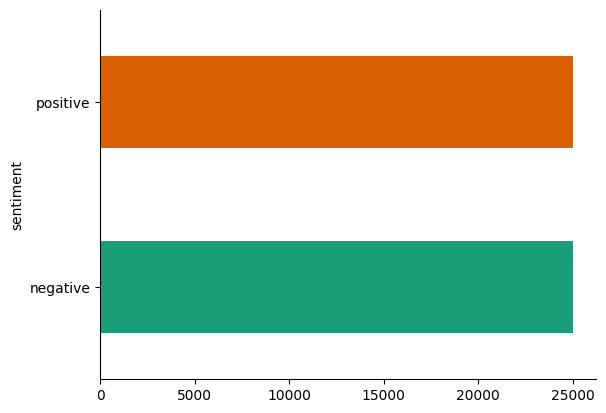

In [65]:
# sentiment

from matplotlib import pyplot as plt
import seaborn as sns
dataset.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### Preparando Train Test Split

In [66]:
import random
# build train and test datasets
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

combined_data = list(zip(reviews, sentiments))
# Mezclar los datos de forma aleatoria
random.shuffle(combined_data)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_data = combined_data[:35000]
test_data = combined_data[35000:]

# Desempaquetar los conjuntos de entrenamiento y prueba
train_reviews, train_sentiments = zip(*train_data)
test_reviews, test_sentiments = zip(*test_data)

# Normalización y Procesamiento de Texto

In [67]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()
    norm_docs.append(doc)

  return norm_docs

In [68]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

 13%|█▎        | 4629/35000 [00:05<00:23, 1287.17it/s]<ipython-input-67-6e112d5e52c8>:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
100%|██████████| 15000/15000 [00:07<00:00, 1879.44it/s]

CPU times: user 26.3 s, sys: 173 ms, total: 26.4 s
Wall time: 29.7 s


## Preprocesamiento
Para preparar los datos de texto para nuestro modelo de aprendizaje profundo, transformamos cada reseña en una secuencia.
Cada palabra en la reseña se asigna a un índice entero y así la oración se convierte en una secuencia de números.

Para realizar esta transformación, keras proporciona el Tokenizer ```Tokenizer```

In [69]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [70]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('gracethe', 175669), ('<PAD>', 0), 1)

In [71]:
train_sequences = t.texts_to_sequences(norm_train_reviews)

In [72]:
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [73]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=175670
Number of Documents=35000


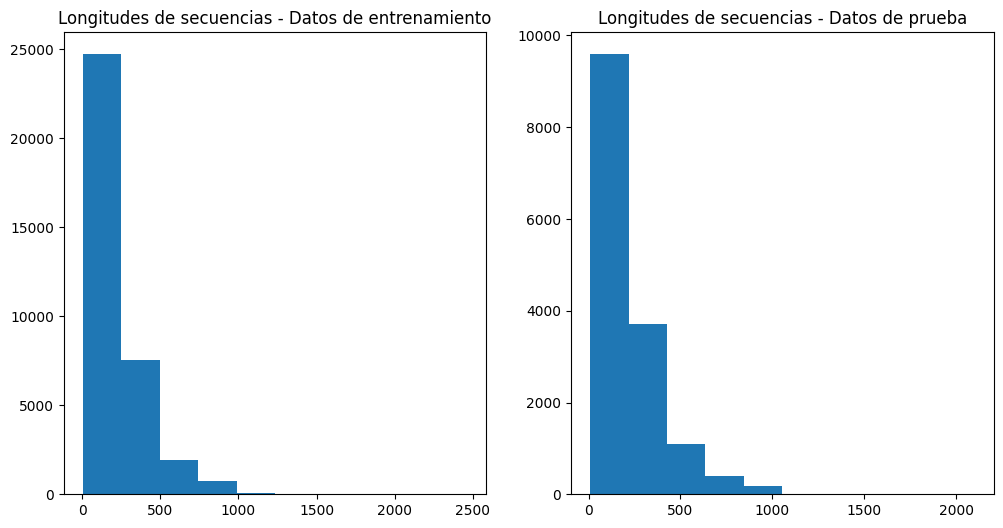

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)
ax[0].set_title('Longitudes de secuencias - Datos de entrenamiento')
ax[1].set_title('Longitudes de secuencias - Datos de prueba')
plt.show()

### Normalización de secuencia

No todas las reseñas tienen la misma longitud.

Para manejar esta diferencia en la longitud de las reseñas, definimos una longitud máxima.

Para las reseñas que son más cortas que esta longitud, las rellenamos con ceros mientras que las más largas son truncadas.

In [75]:
MAX_SEQUENCE_LENGTH = 1000

In [76]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((35000, 1000), (15000, 1000))

### Etiquetas de codificación

El conjunto de datos contiene etiquetas de la forma positivo/negativo.
El siguiente paso codifica las etiquetas usando LabelEncoder de sklearn. ```sklearn's``` ```LabelEncoder```

In [77]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [78]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [79]:
VOCAB_SIZE = len(t.word_index)

## Preparar el modelo
Dado que los datos textuales son una secuencia de palabras, utilizamos convoluciones 1D para escanear las oraciones.

El modelo primero transforma cada palabra en un espacio de embedding/vector de dimensiones más bajas, seguido de convoluciones 1D y luego pasa los datos a través de capas densas antes de la capa final para la clasificación.

In [80]:
EMBED_SIZE = 300
EPOCHS=2
BATCH_SIZE=128

In [81]:
# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1000, 300)         52701000  
                                                                 
 conv1d_6 (Conv1D)           (None, 1000, 128)         153728    
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 500, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 500, 64)           32832     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 250, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_8 (Conv1D)           (None, 250, 32)          

## Model Training

In [82]:
# Fit the model
model.fit(X_train, y_train,
          validation_split=0.1,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          verbose=1)

Epoch 1/2
247/247 [==============================] - 53s 207ms/step - loss: 0.3722 - accuracy: 0.8135 - val_loss: 0.2426 - val_accuracy: 0.9046
Epoch 2/2
247/247 [==============================] - 43s 172ms/step - loss: 0.1138 - accuracy: 0.9594 - val_loss: 0.3927 - val_accuracy: 0.8520


## Model Evaluation

In [83]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

469/469 [==============================] - 3s 7ms/step - loss: 0.3716 - accuracy: 0.8551
Accuracy: 85.51%
